# MovieLens Recomendation Engine Project
By Victor Chen, Brian Matsiko, Erin Vu
_________________________________________________________________________________________________

## Overview

Our project is a recommendation engine that uses collaborative filtering and content based filtering in order to recommend movies to users based off of movie ratings from the MovieLens dataset. 

## Business Problem

Our stakeholder is a new movie streaming service trying to get into the media services business. In order to serve our customer base, we need to understand what they like and what to provide them. Our goal of this project is to build a model that provides the top 5 movie recommendations to a user, based on their ratings of other movies. 
_________________________________________________________________________

## Data Understanding

The data used in this set is from the [MovieLens](https://grouplens.org/datasets/movielens/latest/) dataset. In this project, we will be working with the smaller dataset of 100,000 ratings of 9,000 movies from 600 users. We will use the ratings from the users to make recommendations for movies based off of other users ratings. The dataset was last updated on 9/2018. We are working towards a model that works on the smaller data set and hope to apply it to the larger dataset or another subset of the larget dataset with the same success.
______________________________________

## Data Preparation

In [1]:
# Import standard packages
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pylab import rcParams
from PIL import Image
%matplotlib inline

In [2]:
# Load movies
movies = pd.read_csv("./small_data/ml-latest-small/movies.csv")
#movies = movies.replace({np.nan: None}) # replace NaN with None
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
# Load movies
ratings = pd.read_csv("./small_data/ml-latest-small/ratings.csv")
#ratings = ratings.replace({np.nan: None}) # replace NaN with None
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [47]:
df = pd.merge(movies, ratings)

In [7]:
movies.count()

movieId    9742
title      9742
genres     9742
dtype: int64

In [8]:
ratings.count()

userId       100836
movieId      100836
rating       100836
timestamp    100836
dtype: int64

In [52]:
Average_ratings = pd.DataFrame(df.groupby('title')['rating'].mean())
Average_ratings

,rating
title,
'71,4.000000
'Hellboy': The Seeds of Creation,4.000000
'Round Midnight,3.500000
'Salem's Lot,5.000000
'Til There Was You,4.000000
...,...
eXistenZ,3.863636
xXx,2.770833
xXx: State of the Union,2.000000


In [67]:
Average_ratings['Total Ratings'] = pd.DataFrame(df.groupby('title')['rating'].count())
Average_ratings.head(10)

,rating,Total Ratings
title,,
'71,4.000000,1
'Hellboy': The Seeds of Creation,4.000000,1
'Round Midnight,3.500000,2
'Salem's Lot,5.000000,1
'Til There Was You,4.000000,2
'Tis the Season for Love,1.500000,1
"'burbs, The",3.176471,17
'night Mother,3.000000,1
(500) Days of Summer,3.666667,42


In [10]:
print("If there is missing data in each table?")
print('movie: {}'.format(movies.count() == movies.dropna().count()))
print('ratings: {}'.format(ratings.count() == ratings.dropna().count()))

If there is missing data in each table?
movie: movieId    True
title      True
genres     True
dtype: bool
ratings: userId       True
movieId      True
rating       True
timestamp    True
dtype: bool


In [11]:
#Using regular expressions to find a year stored between parentheses
#We specify the parantheses so we don't conflict with movies that have years in their titles
movies['year'] = movies.title.str.extract('(\(\d\d\d\d\))',expand=False)
#Removing the parentheses
movies['year'] = movies.year.str.extract('(\d\d\d\d)',expand=False)
#Removing the years from the 'title' column
movies['title'] = movies.title.str.replace('(\(\d\d\d\d\))', '')
#Applying the strip function to get rid of any ending whitespace characters that may have appeared
movies['title'] = movies['title'].apply(lambda x: x.strip())
movies.head(10)

,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995
5,6,Heat,Action|Crime|Thriller,1995
6,7,Sabrina,Comedy|Romance,1995
7,8,Tom and Huck,Adventure|Children,1995
8,9,Sudden Death,Action,1995
9,10,GoldenEye,Action|Adventure|Thriller,1995


In [35]:
movies

,movieId,title,genres,year
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995
2,3,Grumpier Old Men,"[Comedy, Romance]",1995
3,4,Waiting to Exhale,"[Comedy, Drama, Romance]",1995
4,5,Father of the Bride Part II,[Comedy],1995
...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic,"[Action, Animation, Comedy, Fantasy]",2017
9738,193583,No Game No Life: Zero,"[Animation, Comedy, Fantasy]",2017
9739,193585,Flint,[Drama],2017
9740,193587,Bungo Stray Dogs: Dead Apple,"[Action, Animation]",2018


total of 20 unique genres from 22084 occurances.


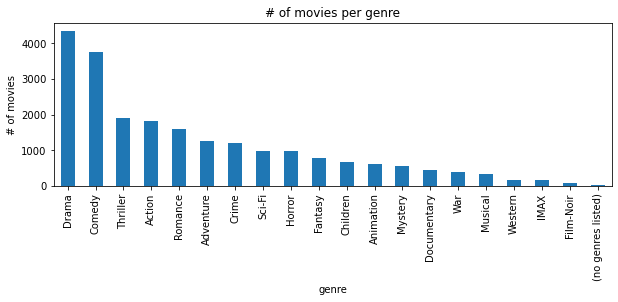

In [36]:
# Genres
all_genres = [s for s in movies[movies.genres.notnull()].genres]
genres = [item for l in all_genres for item in l ]
unique_genres = set(genres)
print (f"total of {len(unique_genres)} unique genres from {len(genres)} occurances.")
pd.Series(genres).value_counts().plot(kind='bar', figsize=(10, 3))
plt.title("# of movies per genre")
plt.ylabel("# of movies")
plt.xlabel("genre")
plt.show()

Total of 106 uinque years from 1902 to 2018


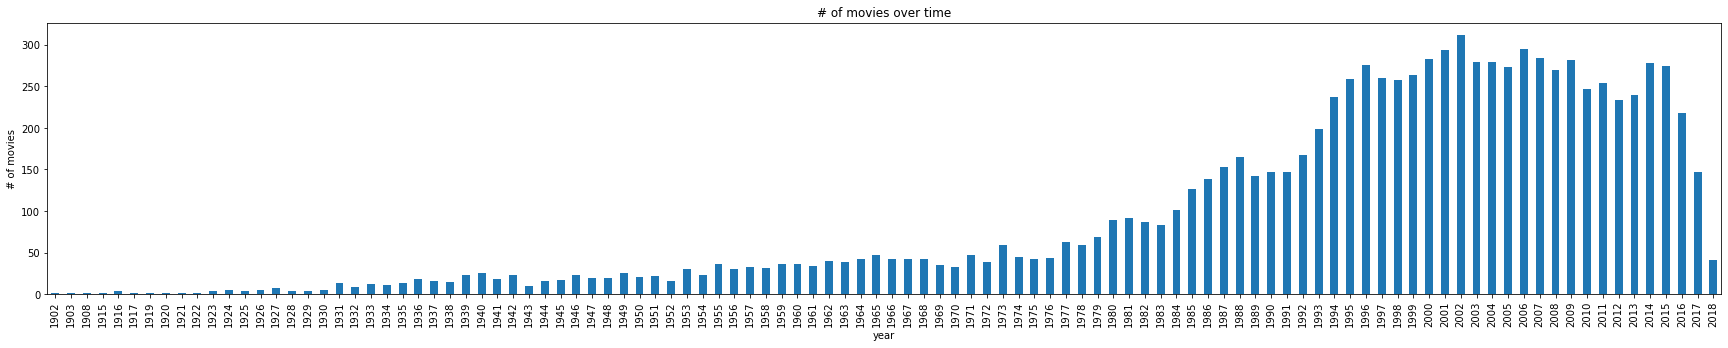

In [13]:
# Years
years = movies[movies.year.notnull()].year # get rows where year is not None
print (f"Total of {len(set(years))} uinque years from {min(years)} to {max(years)}")
pd.Series(years).value_counts().sort_index().plot(kind='bar', figsize=(30, 5))
plt.title("# of movies over time")
plt.ylabel("# of movies")
plt.xlabel("year")
plt.show()

In [14]:
#Every genre is separated by a | so we simply have to call the split function on |
movies['genres'] = movies.genres.str.split('|')
movies.head(10)

,movieId,title,genres,year
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995
2,3,Grumpier Old Men,"[Comedy, Romance]",1995
3,4,Waiting to Exhale,"[Comedy, Drama, Romance]",1995
4,5,Father of the Bride Part II,[Comedy],1995
5,6,Heat,"[Action, Crime, Thriller]",1995
6,7,Sabrina,"[Comedy, Romance]",1995
7,8,Tom and Huck,"[Adventure, Children]",1995
8,9,Sudden Death,[Action],1995
9,10,GoldenEye,"[Action, Adventure, Thriller]",1995


In [15]:
#Copying the movie dataframe into a new one since we won't need to use the genre information in our first case.
moviesWithGenres = movies.copy()

#For every row in the dataframe, iterate through the list of genres and place a 1 into the corresponding column
for index, row in movies.iterrows():
    for genre in row['genres']:
        moviesWithGenres.at[index, genre] = 1
#Filling in the NaN values with 0 to show that a movie doesn't have that column's genre
moviesWithGenres = moviesWithGenres.fillna(0)
moviesWithGenres.head(10)

,movieId,title,genres,year,Adventure,Animation,Children,Comedy,Fantasy,Romance,...,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed)
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,Grumpier Old Men,"[Comedy, Romance]",1995,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,Waiting to Exhale,"[Comedy, Drama, Romance]",1995,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,Father of the Bride Part II,[Comedy],1995,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,6,Heat,"[Action, Crime, Thriller]",1995,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,7,Sabrina,"[Comedy, Romance]",1995,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,8,Tom and Huck,"[Adventure, Children]",1995,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,9,Sudden Death,[Action],1995,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,10,GoldenEye,"[Action, Adventure, Thriller]",1995,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
#Drop removes a specified row or column from a dataframe
ratings = ratings.drop('timestamp', 1)
ratings.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [17]:
#Merge is a function that combines all the rows of the dataset with the specified dataframe.
data = ratings.merge(movies,on='movieId', how='left')
data.head(10)

,userId,movieId,rating,title,genres,year
0,1,1,4.0,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995
1,1,3,4.0,Grumpier Old Men,"[Comedy, Romance]",1995
2,1,6,4.0,Heat,"[Action, Crime, Thriller]",1995
3,1,47,5.0,Seven (a.k.a. Se7en),"[Mystery, Thriller]",1995
4,1,50,5.0,"Usual Suspects, The","[Crime, Mystery, Thriller]",1995
5,1,70,3.0,From Dusk Till Dawn,"[Action, Comedy, Horror, Thriller]",1996
6,1,101,5.0,Bottle Rocket,"[Adventure, Comedy, Crime, Romance]",1996
7,1,110,4.0,Braveheart,"[Action, Drama, War]",1995
8,1,151,5.0,Rob Roy,"[Action, Drama, Romance, War]",1995
9,1,157,5.0,Canadian Bacon,"[Comedy, War]",1995


## Data Modeling

Below, we will begin our modeling process. We begin with collaborative filtering to build our recommendation engine. Collaborative filtering uses the ratings from the user and measures it up against the other users' ratings.

### Collaborative Filtering Based Recommendation System

In [18]:
from surprise import NormalPredictor
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate, GridSearchCV

# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(1, 5))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

In [19]:
from surprise import BaselineOnly, SVD
from surprise import KNNBasic, KNNWithMeans, KNNBaseline
from surprise import NMF
from surprise import CoClustering
from surprise import SlopeOne
from surprise.model_selection import cross_validate

#### Baseline Model

In [20]:
baseline = BaselineOnly()
baseline_cv = cross_validate(baseline, data, measures=['RMSE'], cv=5, verbose=False)

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


In [21]:
baseline_rmse = np.mean(baseline_cv['test_rmse'])
print(f'Baseline RMSE {baseline_rmse}')

Baseline RMSE 0.8722775652505206


#### Other Models
Below we will cross validate other models to find our best RMSE scoring model and build upon that model.

In [22]:
svd = SVD()
knnbasic = KNNBasic()
nmf = NMF()
coclustering = CoClustering()
slopeone = SlopeOne()
knnwithmeans = KNNWithMeans()

# Run 5-fold cross-validation and print results
svd_dict = cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)
knnbasic_dict = cross_validate(knnbasic, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)
nmf_dict = cross_validate(nmf, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)
coclustering_dict = cross_validate(coclustering, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)
slopeone_dict = cross_validate(slopeone, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)
knnwithmeans_dict = cross_validate(knnwithmeans, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


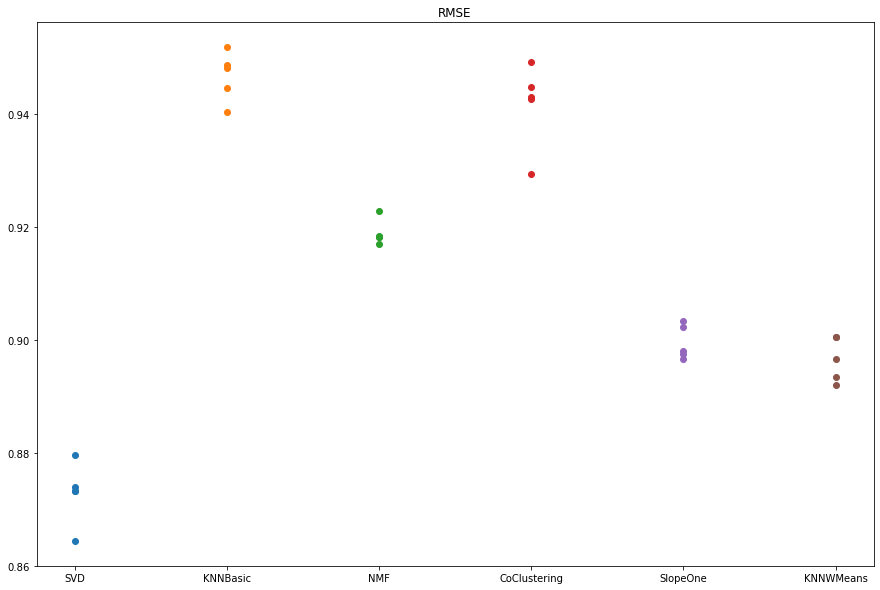

In [68]:
fig, ax = plt.subplots(figsize=(15,10))
algos = ['SVD', 'KNNBasic', 'NMF', 'CoClustering', 'SlopeOne', 'KNNWMeans']
x_pos = np.arange(float(len(algos)))

Y = [svd_dict['test_rmse'], knnbasic_dict['test_rmse'], nmf_dict['test_rmse'], coclustering_dict['test_rmse'], slopeone_dict['test_rmse'], knnwithmeans_dict['test_rmse']]
for y in range(len(Y)):
    plt.scatter([algos[y], algos[y], algos[y], algos[y], algos[y]], Y[y], marker='o')
ax.set_title('RMSE');

Above we can observe that SVD has the lowest rmse and we will continue with gridsearch to find the best parameters for that model.

#### SVD Grid Search

In [25]:
params = {'n_factors': [10, 20, 75],
         'reg_all': [0.01, 0.02, 0.05],
         'lr_all' : [0.0025, 0.005, 0.01, 0.1]}
g_s_svd = GridSearchCV(SVD,param_grid=params,n_jobs=-1,refit=True)

In [26]:
g_s_svd.fit(data)

In [27]:
# print out optimal parameters for SVD after GridSearch
print(g_s_svd.best_score)
print(g_s_svd.best_params)

{'rmse': 0.8594936968166322, 'mae': 0.6592004827702054}
{'rmse': {'n_factors': 75, 'reg_all': 0.05, 'lr_all': 0.01}, 'mae': {'n_factors': 75, 'reg_all': 0.05, 'lr_all': 0.01}}


In [52]:
g_s_svd.__dict__

{'algo_class': surprise.prediction_algorithms.matrix_factorization.SVD,
 'measures': ['rmse', 'mae'],
 'cv': None,
 'refit': 'rmse',
 'return_train_measures': False,
 'n_jobs': -1,
 'pre_dispatch': '2*n_jobs',
 'joblib_verbose': 0,
 'param_grid': {'n_factors': [20, 50, 100], 'reg_all': [0.02, 0.05, 0.1]},
 'param_combinations': [{'n_factors': 20, 'reg_all': 0.02},
  {'n_factors': 20, 'reg_all': 0.05},
  {'n_factors': 20, 'reg_all': 0.1},
  {'n_factors': 50, 'reg_all': 0.02},
  {'n_factors': 50, 'reg_all': 0.05},
  {'n_factors': 50, 'reg_all': 0.1},
  {'n_factors': 100, 'reg_all': 0.02},
  {'n_factors': 100, 'reg_all': 0.05},
  {'n_factors': 100, 'reg_all': 0.1}],
 'best_index': {'rmse': 0, 'mae': 0},
 'best_params': {'rmse': {'n_factors': 20, 'reg_all': 0.02},
  'mae': {'n_factors': 20, 'reg_all': 0.02}},
 'best_score': {'rmse': 0.8688336366070459, 'mae': 0.668022479149676},
 'best_estimator': {'rmse': <surprise.prediction_algorithms.matrix_factorization.SVD at 0x226d72f35b0>,
  'mae':

In [28]:
trainset = data.build_full_trainset()
svd_best = SVD(n_factors= 75, reg_all=0.05, lr_all=.01)
svd_best.fit(trainset)

In [30]:
from collections import defaultdict

def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [31]:
# Than predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()
predictions = svd_best.test(testset)

top_n = get_top_n(predictions, n=10)

# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

1 [318, 1704, 48516, 720, 898, 904, 908, 910, 912, 930]
2 [177593, 898, 5690, 1223, 1197, 306, 106642, 899, 3451, 1228]
3 [2617, 3152, 7156, 733, 866, 3473, 1280, 3468, 898, 3543]
4 [1212, 77800, 318, 4334, 142488, 306, 1299, 858, 1172, 7323]
5 [3451, 1204, 858, 1237, 2360, 246, 3030, 3037, 51931, 750]
6 [3451, 177593, 158966, 3275, 7121, 1270, 3429, 898, 94070, 34405]
7 [858, 318, 913, 1212, 2571, 898, 3468, 3152, 1198, 1250]
8 [3451, 51931, 928, 5690, 142488, 2324, 1213, 1172, 2959, 58]
9 [1196, 260, 3451, 589, 318, 2571, 858, 1217, 296, 1178]
10 [1172, 899, 69757, 111781, 910, 2557, 1755, 151, 105504, 6016]
11 [1178, 3451, 899, 912, 778, 3083, 527, 4144, 3508, 1217]
12 [110, 260, 356, 457, 527, 1196, 1210, 1222, 1258, 1617]
13 [296, 1204, 2959, 4993, 858, 7153, 1945, 1178, 750, 1280]
14 [177593, 5690, 1276, 1262, 3030, 3435, 3836, 306, 926, 1248]
15 [6460, 92259, 1172, 5500, 1267, 1203, 778, 50, 1282, 74458]
16 [177593, 106642, 3451, 1104, 92535, 898, 4642, 3266, 7156, 2732]
17 [345

416 [475, 1203, 4334, 1136, 44555, 3468, 3030, 293, 904, 933]
417 [1178, 4973, 898, 1217, 3451, 3435, 50, 6460, 1719, 527]
418 [914, 3949, 260, 1199, 750, 168252, 6874, 8874, 1196, 858]
419 [5952, 4993, 177593, 3451, 6104, 898, 928, 7153, 176, 905]
420 [3451, 177593, 1197, 898, 475, 106642, 3347, 246, 1217, 5500]
421 [3451, 2959, 1217, 5618, 858, 1041, 1104, 177593, 3200, 296]
422 [1196, 930, 1208, 89904, 177593, 6787, 296, 79132, 1221, 527]
423 [527, 912, 5618, 2732, 475, 6818, 898, 148881, 1237, 3468]
424 [3451, 177593, 1283, 1041, 148626, 3201, 898, 3266, 6791, 2067]
425 [3451, 2542, 898, 177593, 3468, 1178, 174053, 5690, 62336, 7156]
426 [1097, 76093, 177593, 912, 1237, 80906, 3451, 1277, 3429, 42728]
427 [318, 58559, 720, 260, 912, 177593, 1225, 1246, 4878, 1178]
428 [750, 608, 858, 4226, 1221, 3468, 3949, 866, 94959, 1217]
429 [1237, 3836, 7008, 56782, 177593, 356, 3451, 1213, 97304, 318]
430 [260, 1217, 541, 1136, 32587, 1178, 7153, 27156, 778, 898]
431 [858, 1217, 750, 296, 318

# Content-Based Recommendation system

In [37]:
movies.head()

,movieId,title,genres,year
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995
2,3,Grumpier Old Men,"[Comedy, Romance]",1995
3,4,Waiting to Exhale,"[Comedy, Drama, Romance]",1995
4,5,Father of the Bride Part II,[Comedy],1995


In [38]:
movie_profile = movies[['movieId', 'title', 'genres']]
movie_profile.rename(columns={'id': 'movieId'}, inplace=True)
genres = [item.strip() for l in all_genres for item in l ]
unique_genres = set(genres)
for genre in unique_genres:
    movie_profile[genre] = 0

C:\Users\Erin Vu\anaconda3\envs\learn-env\lib\site-packages\pandas\core\frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [44]:
movies['title'][2121]

'Iron Eagle IV'

In [42]:
userInput = [
            {'title':'Iron Eagle IV)', 'rating':4},
            {'title':'Vow, The', 'rating':4.5},
            {'title':'Killing Zoe', 'rating':3},
            {'title':"Dead Like Me: Life After Death", 'rating':3.5},
            {'title':'Training Day', 'rating':5}
         ] 
inputMovies = pd.DataFrame(userInput)
inputMovies

,title,rating
0,"Fast & Furious (Fast and the Furious 4, The)",4.0
1,Jumanji: Welcome to the Jungle,4.5
2,Secret Superstar,3.0
3,Captain Marvel,3.5
4,"Intern, The",5.0


In [43]:
#Filtering out the movies by title
inputId = movies[movies['title'].isin(inputMovies['title'].tolist())]
#Then merging it so we can get the movieId. It's implicitly merging it by title.
inputMovies = pd.merge(inputId, inputMovies)
#Dropping information we won't use from the input dataframe
inputMovies = inputMovies.drop('genres', 1).drop('year', 1)
#Final input dataframe
#If a movie you added in above isn't here, then it might not be in the original 
#dataframe or it might spelled differently, please check capitalisation.
inputMovies

,movieId,title,rating
0,67923,"Fast & Furious (Fast and the Furious 4, The)",4.0
1,179401,Jumanji: Welcome to the Jungle,4.5


In [45]:
#Filtering out the movies from the input
userMovies = moviesWithGenres[moviesWithGenres['movieId'].isin(inputMovies['movieId'].tolist())]
userMovies

,movieId,title,genres,year,Adventure,Animation,Children,Comedy,Fantasy,Romance,...,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed)
7006,67923,"Fast & Furious (Fast and the Furious 4, The)","[Action, Crime, Drama, Thriller]",2009,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9636,179401,Jumanji: Welcome to the Jungle,"[Action, Adventure, Children]",2017,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
#Resetting the index to avoid future issues
userMovies = userMovies.reset_index(drop=True)
#Dropping unnecessary issues due to save memory and to avoid issues
userGenreTable = userMovies.drop('movieId', 1).drop('title', 1).drop('genres', 1).drop('year', 1)
userGenreTable

,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed)
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
inputMovies['rating']

0    4.0
1    4.5
Name: rating, dtype: float64

In [48]:
#Dot produt to get weights
userProfile = userGenreTable.transpose().dot(inputMovies['rating'])
#The user profile
userProfile

Adventure             4.5
Animation             0.0
Children              4.5
Comedy                0.0
Fantasy               0.0
Romance               0.0
Drama                 4.0
Action                8.5
Crime                 4.0
Thriller              4.0
Horror                0.0
Mystery               0.0
Sci-Fi                0.0
War                   0.0
Musical               0.0
Documentary           0.0
IMAX                  0.0
Western               0.0
Film-Noir             0.0
(no genres listed)    0.0
dtype: float64

In [50]:
#Now let's get the genres of every movie in our original dataframe
genreTable = moviesWithGenres.set_index(moviesWithGenres['movieId'])
#And drop the unnecessary information
genreTable = genreTable.drop('movieId', 1).drop('title', 1).drop('genres', 1).drop('year', 1)
genreTable.head()

,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed)
movieId,,,,,,,,,,,,,,,,,,,,
1,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
genreTable.shape

(9742, 20)

In [53]:
#Multiply the genres by the weights and then take the weighted average
recommendationTable = ((genreTable*userProfile).sum(axis=1))/(userProfile.sum())
recommendationTable.head()

movieId
1    0.305085
2    0.305085
3    0.000000
4    0.135593
5    0.000000
dtype: float64

In [54]:
#Sort our recommendations in descending order
recommendationTable = recommendationTable.sort_values(ascending=False)
#Just a peek at the values
recommendationTable.head()

movieId
26504    0.864407
49530    0.847458
459      0.847458
6016     0.847458
81132    0.847458
dtype: float64

In [56]:
#The final recommendation table
movies.loc[movies['movieId'].isin(recommendationTable.head(20).keys())]

,movieId,title,genres,year
400,459,"Getaway, The","[Action, Adventure, Crime, Drama, Romance, Thr...",1994
1747,2344,Runaway Train,"[Action, Adventure, Drama, Thriller]",1985
1814,2414,Young Sherlock Holmes,"[Action, Adventure, Children, Fantasy, Mystery...",1985
1822,2422,"Karate Kid, Part III, The","[Action, Adventure, Children, Drama]",1989
1828,2429,Mighty Joe Young,"[Action, Adventure, Drama, Fantasy, Thriller]",1998
2623,3508,"Outlaw Josey Wales, The","[Action, Adventure, Drama, Thriller, Western]",1976
3085,4142,Left Behind: The Movie,"[Action, Adventure, Drama, Thriller]",2000
4176,6016,City of God (Cidade de Deus),"[Action, Adventure, Crime, Drama, Thriller]",2002
4409,6503,Charlie's Angels: Full Throttle,"[Action, Adventure, Comedy, Crime, Thriller]",2003
4859,7262,Catch That Kid,"[Action, Adventure, Children, Comedy, Crime]",2004
